# Kaggle Histopathology
# Model with Best Results
Use of UNI2-h foundation model with a Linear head and a fine-tuning of hyperparameters

In [1]:
import random 
from pathlib import Path

from huggingface_hub import login
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torchmetrics
import torchvision.transforms as transforms
from itertools import chain
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import stainlib
from stainlib.augmentation.augmenter import *
from stainlib.normalization.normalizer import ReinhardStainNormalizer

In [2]:
data_dir = Path("./data/input/raw")
TRAIN_IMAGES_PATH = data_dir / 'train.h5'
VAL_IMAGES_PATH = data_dir / 'val.h5'
TEST_IMAGES_PATH = data_dir / 'test.h5'

In [3]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}

In [4]:
for img_data, data_path in zip([train_images, val_images], [TRAIN_IMAGES_PATH, VAL_IMAGES_PATH]):
    with h5py.File(data_path, 'r') as hdf:
        ref_img = np.array(hdf.get('16').get('img'))
        for img_idx in list(hdf.keys()):
            label = int(np.array(hdf.get(img_idx).get('label')))
            center = int(np.array(hdf.get(img_idx).get('metadata'))[0])
            if img_data[center][label] is None:
                img_data[center][label] = np.array(hdf.get(img_idx).get('img'))
            if all(all(value is not None for value in inner_dict.values()) for inner_dict in img_data.values()):
                break
all_data = {**train_images, **val_images}

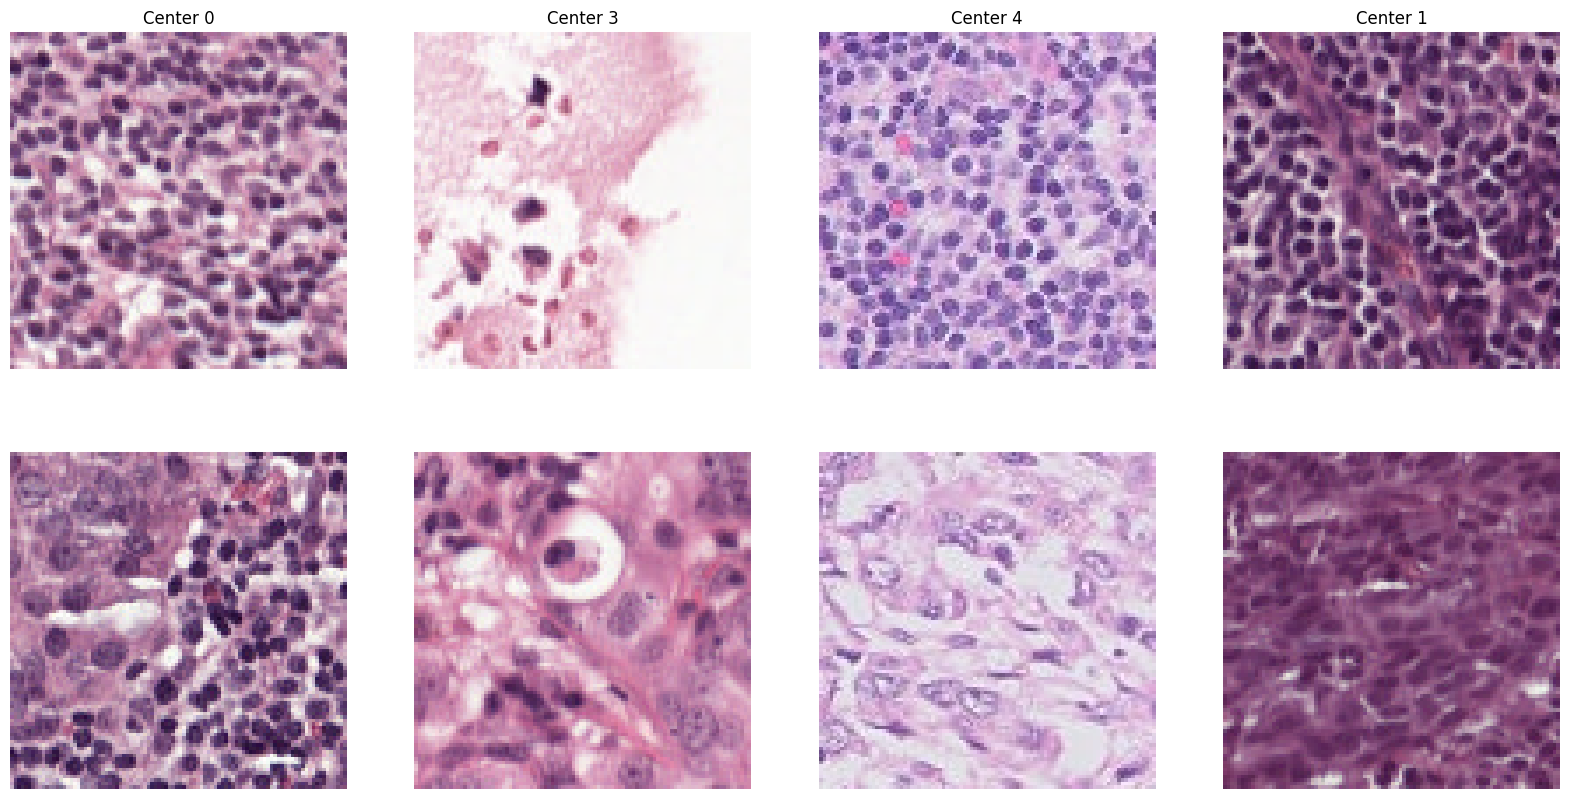

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
center_ids = {center: idx for idx, center in enumerate(all_data.keys())}
for center in all_data:
    for label in all_data[center]:
        axs[label, center_ids[center]].imshow(np.moveaxis(all_data[center][label], 0, -1).astype(np.float32))
        axs[label, center_ids[center]].axis('off')
        if label == 0:
            axs[label, center_ids[center]].set_title(f'Center {center}')
plt.show()

In [6]:
class BaselineDataset(Dataset):
    def __init__(self, dataset_path, preprocessing, mode):
        super(BaselineDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        
        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(np.array(hdf.get(img_id).get('img')))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else self.image_ids[idx]
        return self.preprocessing(img).float(), label

In [7]:
# Preprocessing used for DINOv2 models but not UNI2-h

def grayscale(x):
    t = GrayscaleAugmentor()
    t.fit(x)
    return t.pop()

def hedlightcolor(x):
    t = HedLightColorAugmenter()
    t.randomize()
    return t.transform(x)

def hedlightercolor(x):
    t = HedLighterColorAugmenter()
    t.randomize()
    return t.transform(x)

def hedstrongcolor(x):
    t = HedStrongColorAugmenter()
    t.randomize()
    return t.transform(x)


# Preprocessing 1 (less satisfactory results than Preprocessing 2)
# train_preprocessing = transforms.Compose(
#     [
#         transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomApply(
#             [
#                 transforms.Lambda(lambda x: (255 * x.permute(1, 2, 0)).to(torch.uint8)),
#                 transforms.Lambda(lambda x: hedlightcolor(x.numpy())),
#                 transforms.RandomChoice(
#                     [
#                         transforms.Lambda(lambda x: grayscale(x.numpy())),
#                         transforms.Lambda(lambda x: hedlightcolor(x.numpy())),
#                         transforms.Lambda(lambda x: hedlightercolor(x.numpy())),
#                         transforms.Lambda(lambda x: hedstrongcolor(x.numpy())),
#                     ],
#                 ),
#                 transforms.ToTensor(),
#             ],
#             p=0.25,
#         ),
#         preprocessing,
#     ]
# )

# Preprocessing 2 (Improved performance on DINOv2)
# preprocessing = transforms.Compose(
#     [
#         transforms.Resize(98), 
#         transforms.Lambda(lambda x: 255 * x),
#         transforms.Normalize(
#             mean=(123.675, 116.28, 103.53),
#             std=(58.395, 57.12, 57.375),
#         ),
#     ]
# )

In [8]:
# Function used for Stain Normalization (used in the first preprocessing with DINOv2)

def reinhard_normalization(image):
    normalizer = ReinhardStainNormalizer()
    target = (ref_img * 255).astype(np.uint8)
    target = target.transpose(1, 2, 0)
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()    
    image = (image * 255).astype(np.uint8)
    image = image.transpose(1, 2, 0)

    target = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(target)
    to_transform = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(image)
    normalizer.fit(target)    
    transformed = normalizer.transform(to_transform, mask_background=False)
    normalized_tensor = torch.tensor(transformed).permute(2, 0, 1)
    return normalized_tensor/255

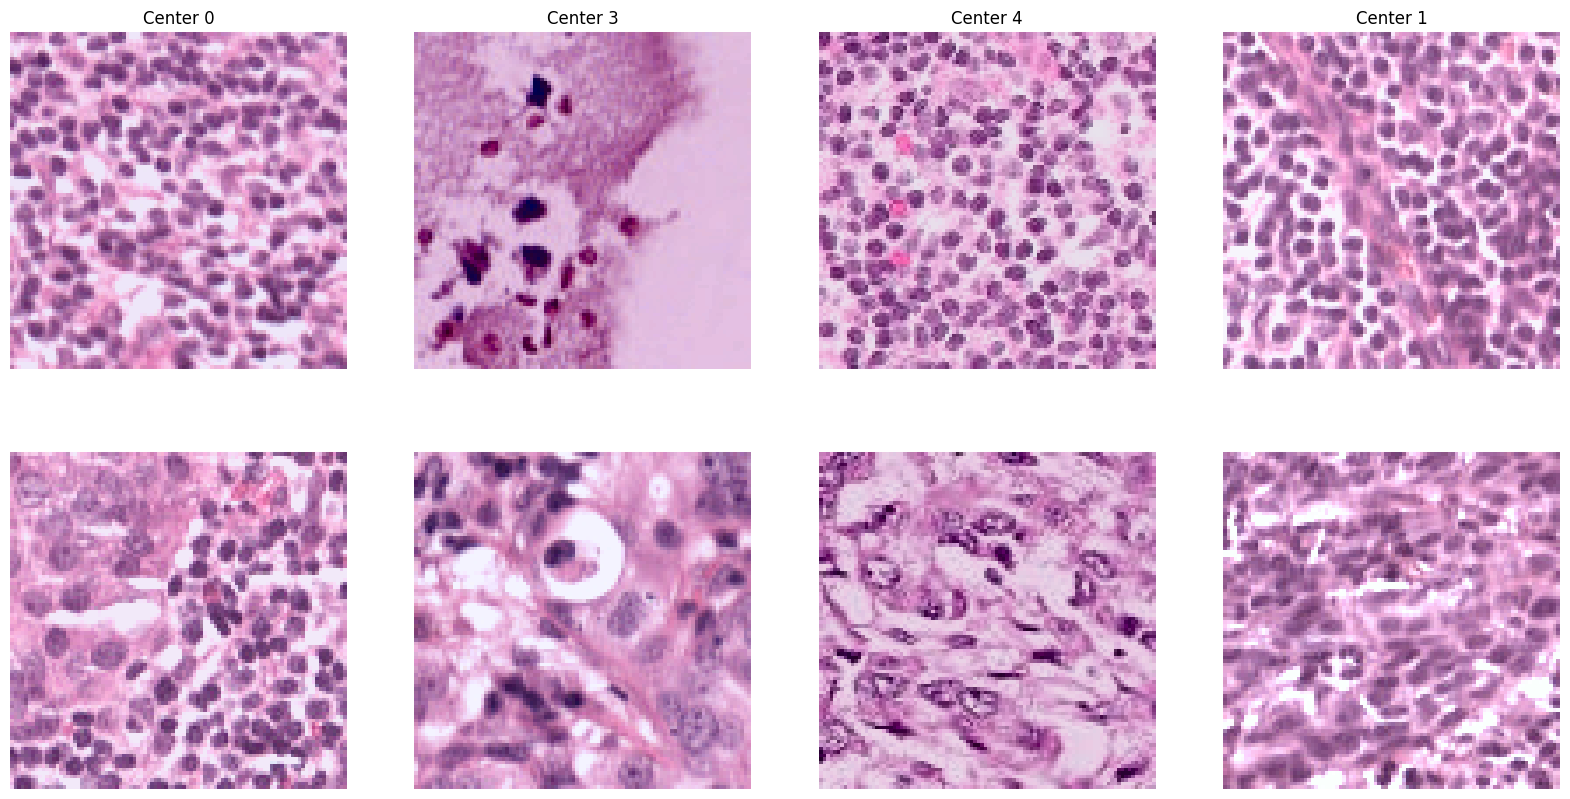

In [9]:
# Example of Reinhard Normalization

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
center_ids = {center: idx for idx, center in enumerate(all_data.keys())}
for center in all_data:
    for label in all_data[center]:
        reinhard_img = reinhard_normalization(all_data[center][label]).permute(1, 2, 0)
        axs[label, center_ids[center]].imshow(reinhard_img)
        axs[label, center_ids[center]].axis('off')
        if label == 0:
            axs[label, center_ids[center]].set_title(f'Center {center}')
plt.show()

In [10]:
login()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')

Working on cuda.


In [12]:
# Loading of UNI2-h
# pretrained=True needed to load UNI2-h weights (and download weights for the first time)
timm_kwargs = {
            'img_size': 224, 
            'patch_size': 14, 
            'depth': 24,
            'num_heads': 24,
            'init_values': 1e-5, 
            'embed_dim': 1536,
            'mlp_ratio': 2.66667*2,
            'num_classes': 0, 
            'no_embed_class': True,
            'mlp_layer': timm.layers.SwiGLUPacked, 
            'act_layer': torch.nn.SiLU, 
            'reg_tokens': 8, 
            'dynamic_img_size': True
        }
device = torch.device("cuda")
model = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs).to(device)
transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [13]:
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, transform, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, transform, 'train')
test_dataset = BaselineDataset(TEST_IMAGES_PATH, transform, 'test')

In [14]:
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=16, num_workers=8, pin_memory=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=16, num_workers=8, pin_memory=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=16, drop_last=False, num_workers=8, pin_memory=True)

In [ ]:
# Extract features and save them to disk to avoid redundant computation on future runs

features = []
labels = []
with torch.no_grad(), torch.autocast(device_type="cuda"):
    for train_x, train_y in tqdm(train_dataloader):
        feat_x = model(train_x.to(device)).cpu()
        features.append(feat_x)
        labels.append(train_y)

In [ ]:
train_x = torch.concatenate(features, dim=0)
train_y = torch.concatenate(labels, dim=0)
torch.save({"features": train_x, "labels": train_y}, "./data/input/preprocessed/train_unih.pt")

In [ ]:
features = []
labels = []
with torch.no_grad(), torch.autocast(device_type="cuda"):
    for val_x, val_y in tqdm(val_dataloader):
        feat_x = model(val_x.to(device)).cpu()
        features.append(feat_x)
        labels.append(val_y)

In [ ]:
val_x = torch.concatenate(features, dim=0)
val_y = torch.concatenate(labels, dim=0)
torch.save({"features": val_x, "labels": val_y}, "./data/input/preprocessed/val_unih.pt")

In [ ]:
features = []
labels = []
with torch.no_grad(), torch.autocast(device_type="cuda"):
    for test_x, test_y in tqdm(test_dataloader):
        feat_x = model(test_x.to(device)).cpu()
        features.append(feat_x)
        labels.extend(test_y)

In [ ]:
test_x = torch.concatenate(features, dim=0)
test_y = torch.concatenate(labels, dim=0)
torch.save({"features": test_x, "labels": labels}, "./data/input/preprocessed/test_unih.pt")

In [15]:
train_dict = torch.load("./data/input/preprocessed/train_unih.pt")
val_dict = torch.load("./data/input/preprocessed/val_unih.pt")
test_dict = torch.load("./data/input/preprocessed/test_unih.pt")

In [16]:
train_x, train_y = train_dict["features"], train_dict["labels"]
val_x, val_y = val_dict["features"], val_dict["labels"]
test_x, test_y = test_dict["features"], test_dict["labels"]

In [17]:
from skorch import NeuralNetClassifier

torch.random.manual_seed(0)

# Linear Classifier
net = NeuralNetClassifier(
    torch.nn.Linear(1536, 2).to("cuda"),
    max_epochs=10,
    lr=2e-4,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    optimizer__weight_decay=0,
    criterion=torch.nn.CrossEntropyLoss,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    iterator_train__batch_size=8,
)

net.fit(train_x.to("cuda"), train_y.to("cuda"))
print(f"Accuracy on validation (OOD): {net.score(val_x, val_y)}")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.0466       0.9913        0.0290  5.6463
      2        0.0275       0.9920        0.0257  5.6350
      3        0.0248       0.9922        0.0244  5.6128
      4        0.0233       0.9925        0.0232  5.6406
      5        0.0223       0.9926        0.0226  5.6304
      6        0.0214       0.9926        0.0219  5.6338
      7        0.0207       0.9927        0.0216  5.6700
      8        0.0202       0.9928        0.0210  5.7374
      9        0.0196       0.9929        0.0207  5.7026
     10        0.0192       0.9930        0.0206  5.7184
Accuracy on validation (OOD): 0.9853025441210177


In [18]:
# Generating the results

test_dict = torch.load("./data/input/preprocessed/test_unih.pt")
test_x, test_y = test_dict["features"], test_dict["labels"]
test_y = list(chain.from_iterable(test_y))

In [19]:
test_pred = net.predict(test_x.to(device))

In [20]:
pd.DataFrame({"ID": test_y, "Pred": test_pred}).set_index('ID').to_csv("data/output/unih.csv")